In [3]:
include("../CovarianceFunctions/CovarianceFunctions.jl")
include("./MCMC.jl")

emcee_Run

In [4]:
using LinearAlgebra
using Logging
using PyPlot
using Distributions
using KernelDensity
using ReverseDiff
using StatsBase

In [24]:
abstract type AbstractPDEs end
struct NonlinElliptic2d{Tα,Tm,TΩ} <: AbstractPDEs
    # eqn: -Δu + α*u^m = f in [Ω[1,1],Ω[2,1]]*[Ω[1,2],Ω[2,2]]
    α::Tα
    m::Tm
    Ω::TΩ
    bdy::Function
    rhs::Function
end

## sample points
function sample_points_rdm(eqn::NonlinElliptic2d, N_domain, N_boundary)
    Ω = eqn.Ω
    x1l = Ω[1,1]
    x1r = Ω[2,1]
    x2l = Ω[1,2]
    x2r = Ω[2,2]   

    X_domain = hcat(rand(Float64,(N_domain, 1))*(x1r-x1l).+x1l,rand(Float64,(N_domain, 1))*(x2r-x2l).+x2l)

    N_bd_each=convert(Int64, N_boundary/4)
    if N_boundary != 4 * N_bd_each
        println("[sample points] N_boundary not divided by 4, replaced by ", 4 * N_bd_each)
        N_boundary = 4 * N_bd_each
    end

    X_boundary = zeros((N_boundary, 2))
    # bottom face
    X_boundary[1:N_bd_each, :] = hcat((x1r-x1l)*rand(Float64,(N_bd_each,1)).+x1l, x2l*ones(N_bd_each))
    # right face
    X_boundary[N_bd_each+1:2*N_bd_each, :] = hcat(x1r*ones(N_bd_each),(x2r-x2l)*rand(Float64,(N_bd_each,1)).+x2l)
    # top face
    X_boundary[2*N_bd_each+1:3*N_bd_each, :] = hcat((x1r-x1l)*rand(Float64,(N_bd_each,1)).+x1l, x2r*ones(N_bd_each))

    # left face
    X_boundary[3*N_bd_each+1:N_boundary, :] = hcat(x1l*ones(N_bd_each), (x2r-x2l)*rand(Float64,(N_bd_each,1)).+x2l)
    return X_domain', X_boundary'
end

function sample_points_grid(eqn::NonlinElliptic2d, h_in, h_bd)
    Ω = eqn.Ω
    x1l = Ω[1,1]
    x1r = Ω[2,1]
    x2l = Ω[1,2]
    x2r = Ω[2,2]
    x = x1l + h_in:h_in:x1r-h_in
    y = x2l + h_in:h_in:x2r-h_in
    X_domain = reduce(hcat,[[x[i], y[j]] for i in 1:length(x) for j in 1:length(x)])

    l = length(x1l:h_bd:x1r-h_bd)
    X_boundary = vcat([x1l:h_bd:x1r-h_bd x2l*ones(l)], [x1r*ones(l) x2l:h_bd:x2r-h_bd], [x1r:-h_bd:x1l+h_bd x2r*ones(l)], [x1l*ones(l) x2r:-h_bd:x1l+h_bd])
    return X_domain, X_boundary'
end


# assemby Gram matrices
function get_Gram_matrices(eqn::NonlinElliptic2d, cov::AbstractCovarianceFunction, X_domain, X_boundary)
    
    d = 2
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    Δδ_coefs = -1.0

    meas_δ_bd = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_δ_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
    meas_Δδ = [ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, 0.0) for i = 1:N_domain]

    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,3)
    measurements[1] = meas_δ_bd; measurements[2] = meas_δ_int; measurements[3] = meas_Δδ

    Theta_big = zeros(2*N_domain+N_boundary,2*N_domain+N_boundary)
    cov(Theta_big, reduce(vcat,measurements))
    return Theta_big
end
            
function get_Gram_matrices(eqn::NonlinElliptic2d, cov::AbstractCovarianceFunction, X_domain, X_boundary, sol_now)
    d = 2
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)
    Δδ_coefs = -1.0
    δ_coefs_int = eqn.α*eqn.m*(sol_now.^(eqn.m-1)) 

    # get linearized PDEs correponding measurements
    meas_δ = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_Δδ = [ΔδPointMeasurement{Float64,d}(SVector{d,Float64}(X_domain[:,i]), Δδ_coefs, δ_coefs_int[i]) for i = 1:N_domain]
    meas_test_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]

    Theta_train = zeros(N_domain+N_boundary,N_domain+N_boundary)

    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ; measurements[2] = meas_Δδ
    cov(Theta_train, reduce(vcat,measurements))
    
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    cov(Theta_test, meas_test_int, reduce(vcat,measurements))
    return Theta_train, Theta_test
end

function  get_initial_covariance(cov::AbstractCovarianceFunction, X_domain, X_boundary)
    d = 2
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)
    meas_δ_bd = [PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_bd_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
    Theta_initial = zeros(N_domain+N_boundary,N_domain+N_boundary)
    measurements = Vector{Vector{<:AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ_bd; measurements[2] = meas_bd_int
    cov(Theta_initial, reduce(vcat,measurements))
    return Theta_initial
end

function  get_initial_covariance(cov::AbstractCovarianceFunction, X_domain)
    d = 2
    N_domain = size(X_domain,2)

    meas_bd_int = [PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]

    Theta_initial = zeros(N_domain,N_domain)
    cov(Theta_initial, meas_bd_int)
    return Theta_initial
end
                                
# Laplace Approximation
function KalmanLaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps; nugget = 1e-12)
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_train = zeros(N_domain+N_boundary, N_domain+N_boundary) 
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    v = sol_init
    rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
    noise_cov = diagm(vcat([noise_var_bd for _ in 1:N_boundary], [noise_var_int for _ in 1:N_domain]))
    for _ in 1:GNsteps
        Theta_train, Theta_test = get_Gram_matrices(eqn, cov, X_domain, X_boundary, v)
        rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
        v = Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    end

    MAP = v
    Cov_init = get_initial_covariance(cov, X_domain) # only consider UQ of domain pts
    Cov_posterior = Cov_init .- Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\Theta_test')
    approx_rkhs_norm2 = rhs_now'* (((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    return MAP, Cov_posterior, approx_rkhs_norm2
end 


function log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-14)

    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_big = zeros(2*N_domain+N_boundary, 2*N_domain+N_boundary)
    Theta_big = get_Gram_matrices(eqn, cov, X_domain, X_boundary)
    U = cholesky(Theta_big+nugget*diagm(diag(Theta_big))).U  #Theta = U'*U

    function d_log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        tmp = U\(U'\Z)
        return -0.5*Z'*tmp, -tmp[N_boundary+1:N_boundary+N_domain] + eqn.α*eqn.m*(z.^(eqn.m-1)).*tmp[N_boundary+N_domain+1:end]
    end
    return d_log_post
end


function hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-9)
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    # get the rhs and bdy data
    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)
    Theta_big = zeros(2*N_domain+N_boundary, 2*N_domain+N_boundary)
    Theta_big = get_Gram_matrices(eqn, cov, X_domain, X_boundary)
    inv_Theta_big = inv(Theta_big + nugget*diagm(diag(Theta_big)))
    function log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        return -0.5*Z'*inv_Theta_big*Z
    end
                                                                
    function hessian_log_post(z)
        Z = vcat(bdy,z,rhs.-eqn.α*z.^eqn.m)
        grad_Z = vcat(zeros(N_boundary,N_domain), Matrix(1.0*I,N_domain,N_domain), -eqn.α*eqn.m*diagm(z.^(eqn.m-1)))
        hess = grad_Z'*(Theta_big\grad_Z)
        for i = 1:N_domain
            for j = 1:2*N_domain+N_boundary
                hess[i,i] += inv_Theta_big[N_domain+N_boundary+i, j]*Z[j]*(-eqn.α)*eqn.m*(eqn.m-1)*z[i]^(eqn.m-2)
            end
        end    
        return -hess
    end
#     function hessian_log_post(z)
#         return ReverseDiff.hessian(log_post,z)
#     end
    return log_post, hessian_log_post
end
                                                                       
                                                                

function LaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps; nugget = 1e-14)
    N_domain = size(X_domain,2)
    N_boundary = size(X_boundary,2)

    rhs = [eqn.rhs(X_domain[:,i]) for i in 1:N_domain] .+ sqrt(noise_var_int) * randn(N_domain)
    bdy = [eqn.bdy(X_boundary[:,i]) for i in 1:N_boundary] .+ sqrt(noise_var_bd) * randn(N_boundary)

    Theta_train = zeros(N_domain+N_boundary, N_domain+N_boundary) 
    Theta_test = zeros(N_domain,N_domain+N_boundary)

    v = sol_init
    rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
    noise_cov = diagm(vcat([noise_var_bd for _ in 1:N_boundary], [noise_var_int for _ in 1:N_domain]))
    for _ in 1:GNsteps
        Theta_train, Theta_test = get_Gram_matrices(eqn, cov, X_domain, X_boundary, v)
        rhs_now = vcat(bdy, rhs.+eqn.α*(eqn.m-1)*v.^eqn.m)
        v = Theta_test*(((Theta_train+noise_cov+nugget*diagm(diag(Theta_train))))\rhs_now)
    end

    MAP = v
    _, hessian_log_post = hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary)
    hessian_mtx = -hessian_log_post(MAP)
    Cov_posterior = inv(hessian_mtx)
    return MAP, Cov_posterior
end 

LaplaceApprox (generic function with 1 method)

In [37]:
α = 10.0
m = 3
Ω = [[0,1] [0,1]]
h_in = 0.2
h_bd = 0.2
lengthscale = 0.3
kernel = "Matern7alf"
cov = MaternCovariance7_2(lengthscale)
noise_var_int = 0.0
noise_var_bd = 0.0
GNsteps = 10

function fun_u(x)
    return sin(pi*x[1])*sin(pi*x[2]) + sin(3*pi*x[1])*sin(3*pi*x[2])
end

function fun_rhs(x)
    ans = 2*pi^2*sin(pi*x[1])*sin(pi*x[2]) + 2*(3*pi)^2*sin(3*pi*x[1])*sin(3*pi*x[2])
    return ans + α*fun_u(x)^m 
end

# boundary value
function fun_bdy(x)
    return fun_u(x)
end

eqn = NonlinElliptic2d(α,m,Ω,fun_bdy,fun_rhs)

NonlinElliptic2d{Float64, Int64, Matrix{Int64}}(10.0, 3, [0 0; 1 1], fun_bdy, fun_rhs)

In [38]:
X_domain, X_boundary = sample_points_grid(eqn, h_in, h_bd)
N_domain = size(X_domain,2)
N_boundary = size(X_boundary,2)

sol_init = zeros(N_domain) # initial solution
truth = [fun_u(X_domain[:,i]) for i in 1:N_domain]

@time MAP, KalmanLaplace_postvar, rkhs_norm2 = KalmanLaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps)
pts_accuracy = sqrt(sum((truth-MAP).^2)/sum(truth.^2))
@info "[L2 accuracy of MAP to true sol] $pts_accuracy"
pts_max_accuracy = maximum(abs.(truth-MAP))/maximum(abs.(truth))
@info "[Linf accuracy of MAP to true sol] $pts_max_accuracy"
sol_std_Kalman = [sqrt(abs(KalmanLaplace_postvar[i,i])) for i in 1:N_domain]

    
@time MAP_Laplace, Laplace_postvar = LaplaceApprox(eqn, cov, X_domain, X_boundary, sol_init, noise_var_int, noise_var_bd, GNsteps)
sol_std = [sqrt(abs(Laplace_postvar[i,i])) for i in 1:N_domain]

  0.054640 seconds (63.69 k allocations: 3.281 MiB, 35.92% gc time, 48.91% compilation time)
  0.007317 seconds (38.33 k allocations: 1.736 MiB)


┌ Info: [L2 accuracy of MAP to true sol] 0.24879550497381783
└ @ Main In[38]:10
┌ Info: [Linf accuracy of MAP to true sol] 0.2118859979269078
└ @ Main In[38]:12


16-element Vector{Float64}:
 0.17503044395640507
 0.22026631134481348
 0.2202663113448151
 0.17503044395640596
 0.22026631134481311
 0.19479517495612628
 0.19479517495612736
 0.22026631134481617
 0.2202663113448173
 0.19479517495612655
 0.19479517495612608
 0.22026631134481564
 0.17503044395640904
 0.22026631134481656
 0.22026631134481456
 0.1750304439564059

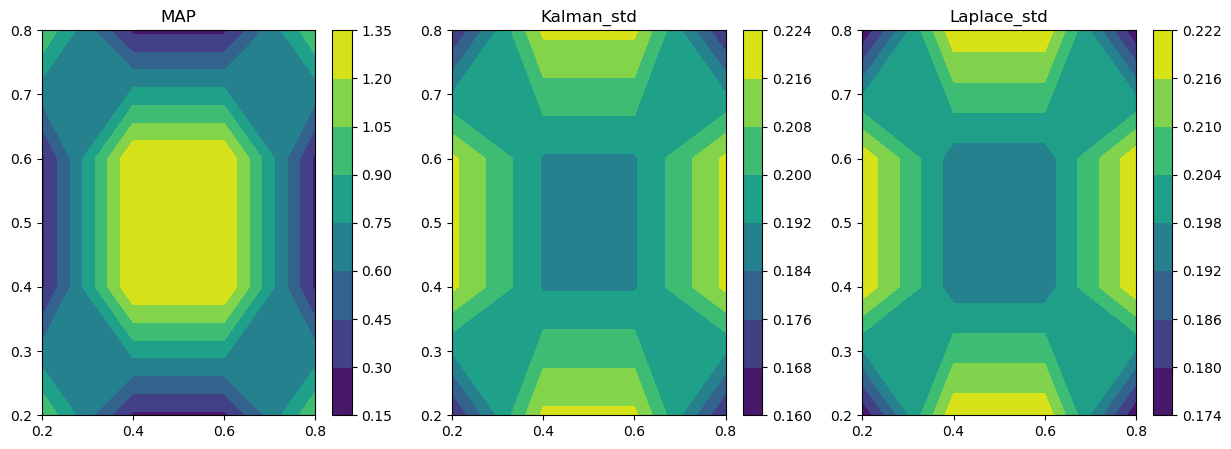

PyObject <matplotlib.colorbar.Colorbar object at 0x7f048ad2fa60>

In [39]:
fig_approx = figure(figsize=(15, 5))
Nh = convert(Int64, 1/h_in-1)
subplot(131)
contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(MAP,Nh,Nh), label = "MAP")
title("MAP")
colorbar()
subplot(132)
contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std_Kalman,Nh,Nh), label = "MAP")
title("Kalman_std")
colorbar()
subplot(133)
contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(sol_std,Nh,Nh), label = "MAP")
title("Laplace_std")
colorbar()
# legend()

In [47]:
emcee_ite = 10^5
log_post, hessian_log_post = hessian_log_post_GP_PDE(eqn, cov, X_domain, X_boundary; nugget = 1e-14)
ensemble_size = 10*N_domain
θ0 = zeros(ensemble_size, N_domain)
for i in 1:ensemble_size
    θ0[i,:] = MAP + rand(Normal(0,1), N_domain)
end
emcee_samples = emcee_Run(log_post, θ0, emcee_ite)
print("")

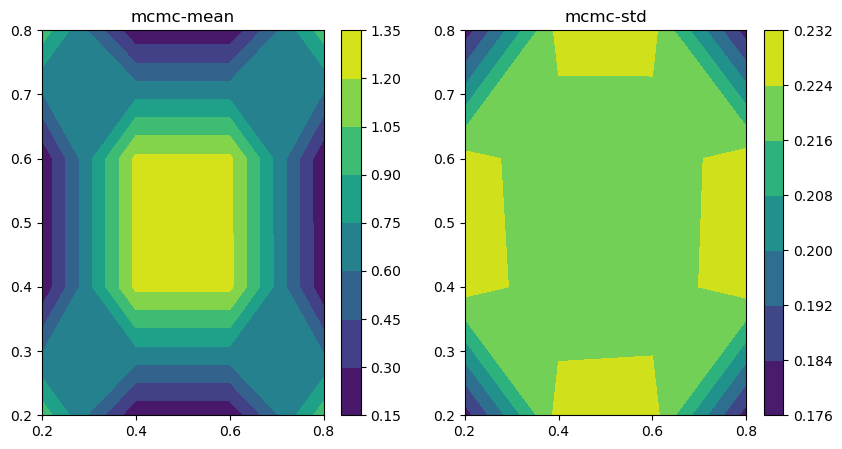

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0485a5ffd0>

In [48]:
mean_emcmc = mean(emcee_samples[emcee_ite÷4:end,:,:], dims=[1,2])
std_emcmc = std(emcee_samples[emcee_ite÷4:end,:,:], dims=[1,2])
fig_approx = figure(figsize=(10, 5))
Nh = convert(Int64, 1/h_in-1)
subplot(121)
contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(mean_emcmc[:],Nh,Nh), label = "mcmc-mean")
title("mcmc-mean")
colorbar()
subplot(122)
contourf(reshape(X_domain[1,:],Nh,Nh), reshape(X_domain[2,:],Nh,Nh), reshape(std_emcmc[:],Nh,Nh), label = "mcmc-std")
title("mcmc-std")
colorbar()
